In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import xgboost as xgb
from shared_funcs import clean_time1, clean_time2, fourwks_n
import shap
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

In [2]:
df_gen1 = pd.read_csv('Plant_1_Generation_Data.csv')
df_wea1 = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

In [3]:
df_gen1['DC_POWER'] = df_gen1['DC_POWER']/10
df_gen1 = clean_time1(df_gen1,'DATE_TIME')
df_wea1 = clean_time2(df_wea1,'DATE_TIME').drop(['SOURCE_KEY'],axis=1)
result1 = pd.merge(df_gen1, df_wea1, how='outer', on=['DATE','HOUR','MINUTE']).dropna()
result1

,DATE_TIME_x,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE,HOUR,MINUTE,DATE_TIME_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,2020-05-15,0,0,2020-05-15 00:00:00,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,2020-05-15,0,0,2020-05-15 00:00:00,25.184316,22.857507,0.0
2,2020-05-15 00:00:00,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,2020-05-15,0,0,2020-05-15 00:00:00,25.184316,22.857507,0.0
3,2020-05-15 00:00:00,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,2020-05-15,0,0,2020-05-15 00:00:00,25.184316,22.857507,0.0
4,2020-05-15 00:00:00,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,2020-05-15,0,0,2020-05-15 00:00:00,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68773,2020-06-17 23:45:00,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,2020-06-17,23,45,2020-06-17 23:45:00,21.909288,20.427972,0.0
68774,2020-06-17 23:45:00,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,2020-06-17,23,45,2020-06-17 23:45:00,21.909288,20.427972,0.0
68775,2020-06-17 23:45:00,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,2020-06-17,23,45,2020-06-17 23:45:00,21.909288,20.427972,0.0
68776,2020-06-17 23:45:00,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,2020-06-17,23,45,2020-06-17 23:45:00,21.909288,20.427972,0.0


## Hypothesis 1:


    HA: Mean production rates and meteorological data associated to maximal energy production for each inverter unit per day can allow for accurate predictions of future production values based on projected meteorological data.
    
    H0: They do not allow for accurate predictions.
    

In [4]:
res1_means = result1.groupby(['SOURCE_KEY','DATE'])[['AC_POWER','DC_POWER','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','IRRADIATION']].agg('mean').reset_index()
res1_max2 = result1.groupby(['SOURCE_KEY','DATE'])[['DAILY_YIELD']].agg('max').reset_index()
res1_information = pd.merge(res1_means, res1_max2, how='outer', on=['SOURCE_KEY','DATE'])
res1_information['SOURCE_KEY'] = label_encoder.fit_transform(res1_information['SOURCE_KEY'])
res1_information

,SOURCE_KEY,DATE,AC_POWER,DC_POWER,MODULE_TEMPERATURE,AMBIENT_TEMPERATURE,IRRADIATION,DAILY_YIELD
0,0,2020-05-15,247.812372,253.054512,32.582964,27.430823,0.204699,5754.0
1,0,2020-05-16,285.505580,291.624858,31.858851,26.780538,0.211951,6292.0
2,0,2020-05-17,293.467187,300.041481,32.740435,26.686727,0.238869,7045.0
3,0,2020-05-18,208.026116,212.531566,27.814344,23.850938,0.159026,4998.0
4,0,2020-05-19,244.528783,249.760503,29.725163,25.338021,0.194031,6449.0
...,...,...,...,...,...,...,...,...
743,21,2020-06-13,345.271019,353.333278,30.481026,24.566729,0.264472,8410.0
744,21,2020-06-14,305.418062,312.013263,29.421707,24.412891,0.220086,7320.0
745,21,2020-06-15,285.134654,291.455822,29.927817,24.827414,0.205925,6820.0
746,21,2020-06-16,260.423214,266.038058,29.555567,24.928929,0.187283,6262.0


In [5]:
model_data, external_data = fourwks_n(res1_information,4)#attempting to split data such that we can predict the next four days

X = res1_information[['SOURCE_KEY','IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','DC_POWER','AC_POWER']]
y = res1_information[['DAILY_YIELD']]
X_in = model_data[['SOURCE_KEY','IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','DC_POWER','AC_POWER']]
y_in = model_data[['DAILY_YIELD']]
X_external = external_data[['SOURCE_KEY','IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','DC_POWER','AC_POWER']]
y_external = external_data[['DAILY_YIELD']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Here we have split the data into two groups. First we have the complete data set on which we can test how well we can predict the daily yield with all 32 days of information.

Second we have split the data into the first 28 days and the last 4 days, where we develop our model with the first 28 days and then test on the 4 days that have been withheld where the data is assumed to be mean values that have been 'forecasted' to see how well a model can predict the daily yeild.

First we will see how well a simple Linear Regression will handle the entirety of the dataset without any tuning of parameters.

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test,y_pred))))

RMSE: 449.66762380750606


In [8]:
data_matrix = xgb.DMatrix(data=X, label=y)

Next we perform a k-fold cross validation to see how well this can be increased

In [9]:
params = {"objective":"reg:squarederror",'colsample_bytree':0.5,'learning_rate':0.16,
         'max_depth':10,'alpha':10,'min_child_weight':5}

cv_results1 = xgb.cv(dtrain = data_matrix,params=params, nfold=10,
                   num_boost_round=5000,early_stopping_rounds=50,
                   metrics="rmse", as_pandas=True,seed=1)
cv_results1.tail(1)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
557,3.451462,0.256053,97.815872,40.116812


In [10]:
xgb_reg = xgb.XGBRegressor(n_estimators=5000, objective='reg:squarederror',learning_rate=0.16,colsample_bytree = 0.5, max_depth=5, min_child_weight = 5, alpha =10)
xgb_reg.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=50)
predictions = xgb_reg.predict(X_test)
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test,predictions))),r2_score(y_test,predictions))

[0]	validation_0-rmse:6103.90772	validation_1-rmse:6150.37061
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5137.45068	validation_1-rmse:5175.50439
[2]	validation_0-rmse:4325.31494	validation_1-rmse:4356.44238
[3]	validation_0-rmse:3642.77173	validation_1-rmse:3667.00220
[4]	validation_0-rmse:3070.39014	validation_1-rmse:3088.91675
[5]	validation_0-rmse:2588.75415	validation_1-rmse:2599.65845
[6]	validation_0-rmse:2184.51880	validation_1-rmse:2189.88574
[7]	validation_0-rmse:1845.90247	validation_1-rmse:1843.47669
[8]	validation_0-rmse:1559.23181	validation_1-rmse:1552.72900
[9]	validation_0-rmse:1319.30933	validation_1-rmse:1310.78503
[10]	validation_0-rmse:1116.30725	validation_1-rmse:1107.00879
[11]	validation_0-rmse:945.37665	validation_1-rmse:931.99292
[12]	validation_0-rmse:802.41638	validation_1-rmse:791.39594
[13]	validation_0-rmse:682.12549	val

[134]	validation_0-rmse:37.56233	validation_1-rmse:92.34020
[135]	validation_0-rmse:37.22946	validation_1-rmse:92.21069
[136]	validation_0-rmse:36.87899	validation_1-rmse:92.04688
[137]	validation_0-rmse:36.46650	validation_1-rmse:92.09750
[138]	validation_0-rmse:36.27217	validation_1-rmse:92.16493
[139]	validation_0-rmse:36.09170	validation_1-rmse:92.13185
[140]	validation_0-rmse:35.95892	validation_1-rmse:92.21615
[141]	validation_0-rmse:35.81904	validation_1-rmse:92.12466
[142]	validation_0-rmse:35.73289	validation_1-rmse:91.97444
[143]	validation_0-rmse:35.61910	validation_1-rmse:91.92550
[144]	validation_0-rmse:35.51989	validation_1-rmse:91.98705
[145]	validation_0-rmse:35.46475	validation_1-rmse:91.99364
[146]	validation_0-rmse:35.33139	validation_1-rmse:91.94960
[147]	validation_0-rmse:35.27229	validation_1-rmse:92.01762
[148]	validation_0-rmse:34.83703	validation_1-rmse:91.55234
[149]	validation_0-rmse:34.58737	validation_1-rmse:91.56390
[150]	validation_0-rmse:34.24017	validat

[271]	validation_0-rmse:23.49358	validation_1-rmse:88.30476
[272]	validation_0-rmse:23.47926	validation_1-rmse:88.28829
[273]	validation_0-rmse:23.32846	validation_1-rmse:88.22459
[274]	validation_0-rmse:23.27288	validation_1-rmse:88.27690
[275]	validation_0-rmse:23.15941	validation_1-rmse:88.20425
[276]	validation_0-rmse:23.13164	validation_1-rmse:88.16990
[277]	validation_0-rmse:23.07728	validation_1-rmse:88.14870
[278]	validation_0-rmse:22.89755	validation_1-rmse:88.09293
[279]	validation_0-rmse:22.83727	validation_1-rmse:88.06044
[280]	validation_0-rmse:22.76776	validation_1-rmse:88.11971
[281]	validation_0-rmse:22.71246	validation_1-rmse:88.18990
[282]	validation_0-rmse:22.68846	validation_1-rmse:88.15310
[283]	validation_0-rmse:22.66541	validation_1-rmse:88.05005
[284]	validation_0-rmse:22.54275	validation_1-rmse:87.97456
[285]	validation_0-rmse:22.52560	validation_1-rmse:87.91708
[286]	validation_0-rmse:22.44966	validation_1-rmse:87.88377
[287]	validation_0-rmse:22.40041	validat

[408]	validation_0-rmse:16.09748	validation_1-rmse:86.17896
[409]	validation_0-rmse:16.03776	validation_1-rmse:86.20300
[410]	validation_0-rmse:16.01973	validation_1-rmse:86.23289
[411]	validation_0-rmse:16.01015	validation_1-rmse:86.22012
[412]	validation_0-rmse:15.99850	validation_1-rmse:86.19951
[413]	validation_0-rmse:15.95067	validation_1-rmse:86.21796
[414]	validation_0-rmse:15.89489	validation_1-rmse:86.20915
[415]	validation_0-rmse:15.88332	validation_1-rmse:86.23473
[416]	validation_0-rmse:15.81376	validation_1-rmse:86.24791
[417]	validation_0-rmse:15.79423	validation_1-rmse:86.23392
[418]	validation_0-rmse:15.76479	validation_1-rmse:86.21046
[419]	validation_0-rmse:15.74541	validation_1-rmse:86.24841
[420]	validation_0-rmse:15.71460	validation_1-rmse:86.23294
[421]	validation_0-rmse:15.67675	validation_1-rmse:86.25961
[422]	validation_0-rmse:15.64061	validation_1-rmse:86.20770
[423]	validation_0-rmse:15.62030	validation_1-rmse:86.18089
[424]	validation_0-rmse:15.56654	validat

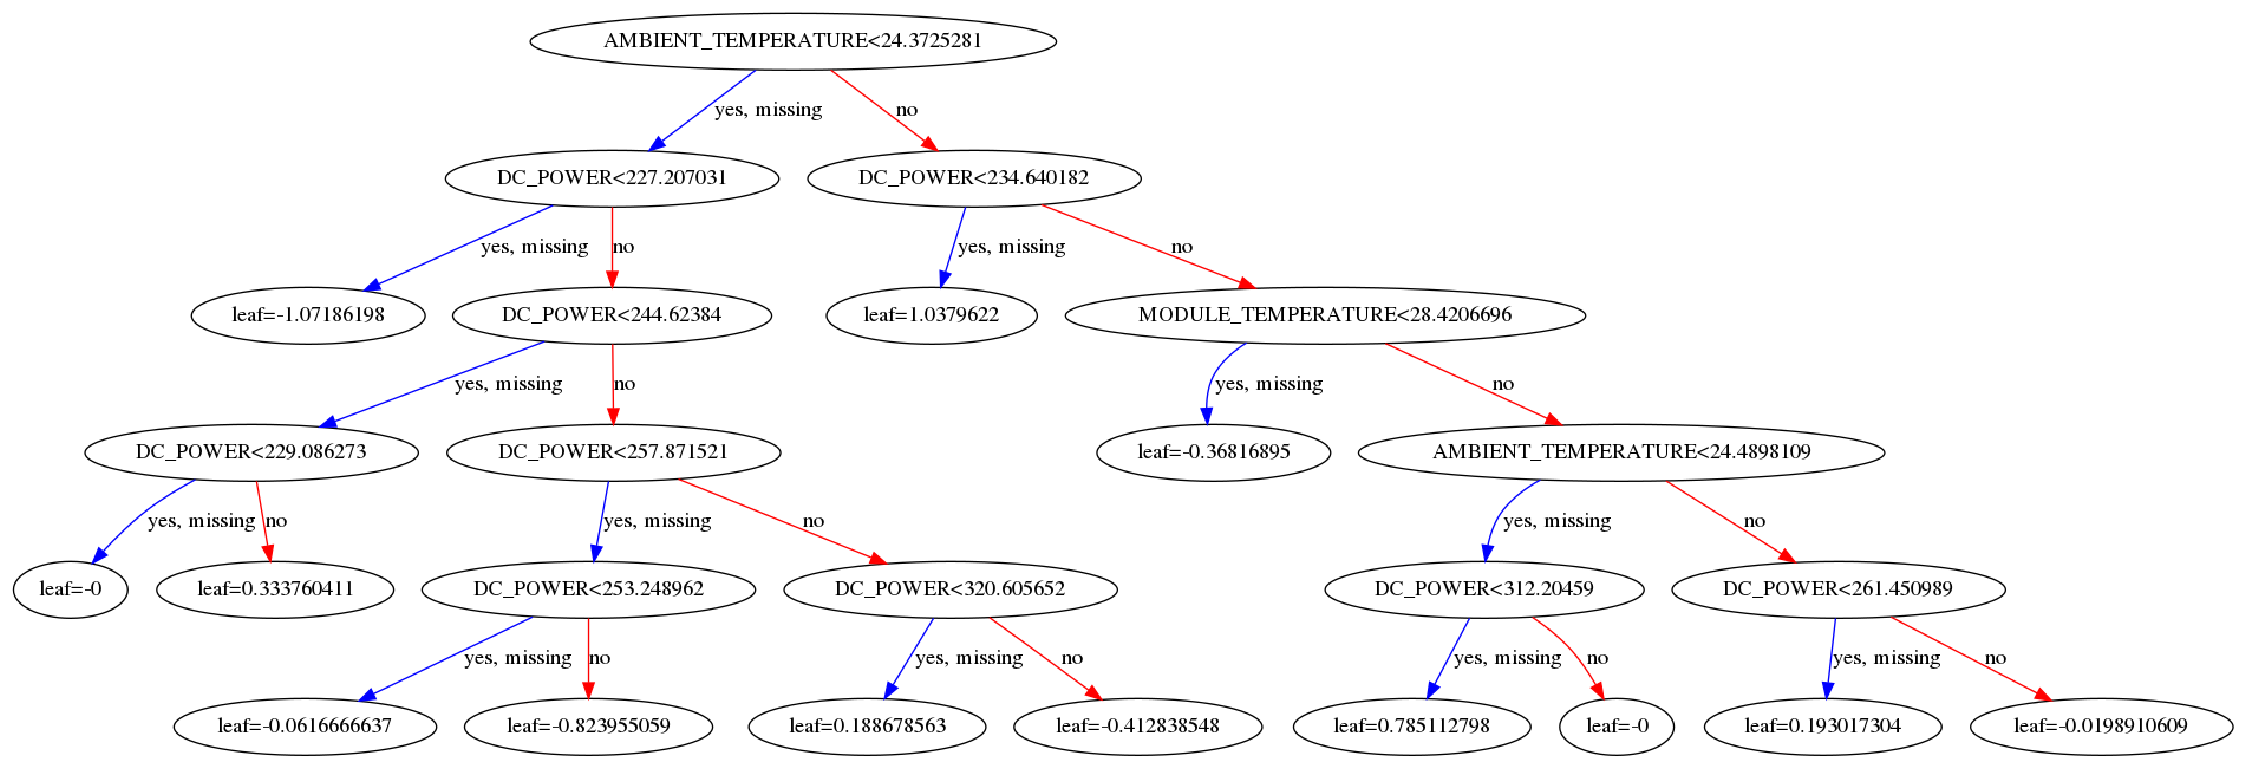

In [11]:
fig, ax = plt.subplots(figsize=(40, 40))
plot_tree(xgb_reg, num_trees=394, ax=ax)
plt.show()

For the entirety of the data we have a high r2-score and a comparatively low RMSE. Next we develop the model for the first 4 weeks of data to predict the last 4 days.

In [12]:
xgbreg = xgb.XGBRegressor(n_estimators=5000, objective='reg:squarederror',learning_rate=0.16,colsample_bytree = 0.5, max_depth=6, min_child_weight = 5)
xgbreg.fit(X_in, y_in, eval_set=[(X_in,y_in),(X_external,y_external)],early_stopping_rounds=50)
preds = xgbreg.predict(X_external)
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_external,preds))),r2_score(y_external,preds))

[0]	validation_0-rmse:6201.61377	validation_1-rmse:5964.87549
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5218.71582	validation_1-rmse:5027.54492
[2]	validation_0-rmse:4393.53369	validation_1-rmse:4275.35303
[3]	validation_0-rmse:3699.71582	validation_1-rmse:3617.49976
[4]	validation_0-rmse:3117.79688	validation_1-rmse:3080.90771
[5]	validation_0-rmse:2629.03955	validation_1-rmse:2623.40112
[6]	validation_0-rmse:2217.48462	validation_1-rmse:2231.53833
[7]	validation_0-rmse:1872.83191	validation_1-rmse:1892.90344
[8]	validation_0-rmse:1583.15454	validation_1-rmse:1617.97864
[9]	validation_0-rmse:1339.12036	validation_1-rmse:1366.99170
[10]	validation_0-rmse:1133.45801	validation_1-rmse:1176.10315
[11]	validation_0-rmse:960.58862	validation_1-rmse:1021.15656
[12]	validation_0-rmse:815.36261	validation_1-rmse:877.14710
[13]	validation_0-rmse:693.26062	va

[133]	validation_0-rmse:29.37673	validation_1-rmse:240.36259
[134]	validation_0-rmse:29.25835	validation_1-rmse:240.35704
[135]	validation_0-rmse:29.11552	validation_1-rmse:240.27084
[136]	validation_0-rmse:28.95476	validation_1-rmse:240.05940
[137]	validation_0-rmse:28.67046	validation_1-rmse:240.08528
[138]	validation_0-rmse:28.56833	validation_1-rmse:239.87279
[139]	validation_0-rmse:28.49973	validation_1-rmse:240.14162
[140]	validation_0-rmse:28.46507	validation_1-rmse:239.96753
[141]	validation_0-rmse:28.36789	validation_1-rmse:240.25192
[142]	validation_0-rmse:28.29420	validation_1-rmse:240.23303
[143]	validation_0-rmse:28.12258	validation_1-rmse:240.02750
[144]	validation_0-rmse:28.04796	validation_1-rmse:239.73967
[145]	validation_0-rmse:27.97479	validation_1-rmse:239.80183
[146]	validation_0-rmse:27.89559	validation_1-rmse:239.74907
[147]	validation_0-rmse:27.85822	validation_1-rmse:239.74948
[148]	validation_0-rmse:27.82838	validation_1-rmse:239.85829
[149]	validation_0-rmse:

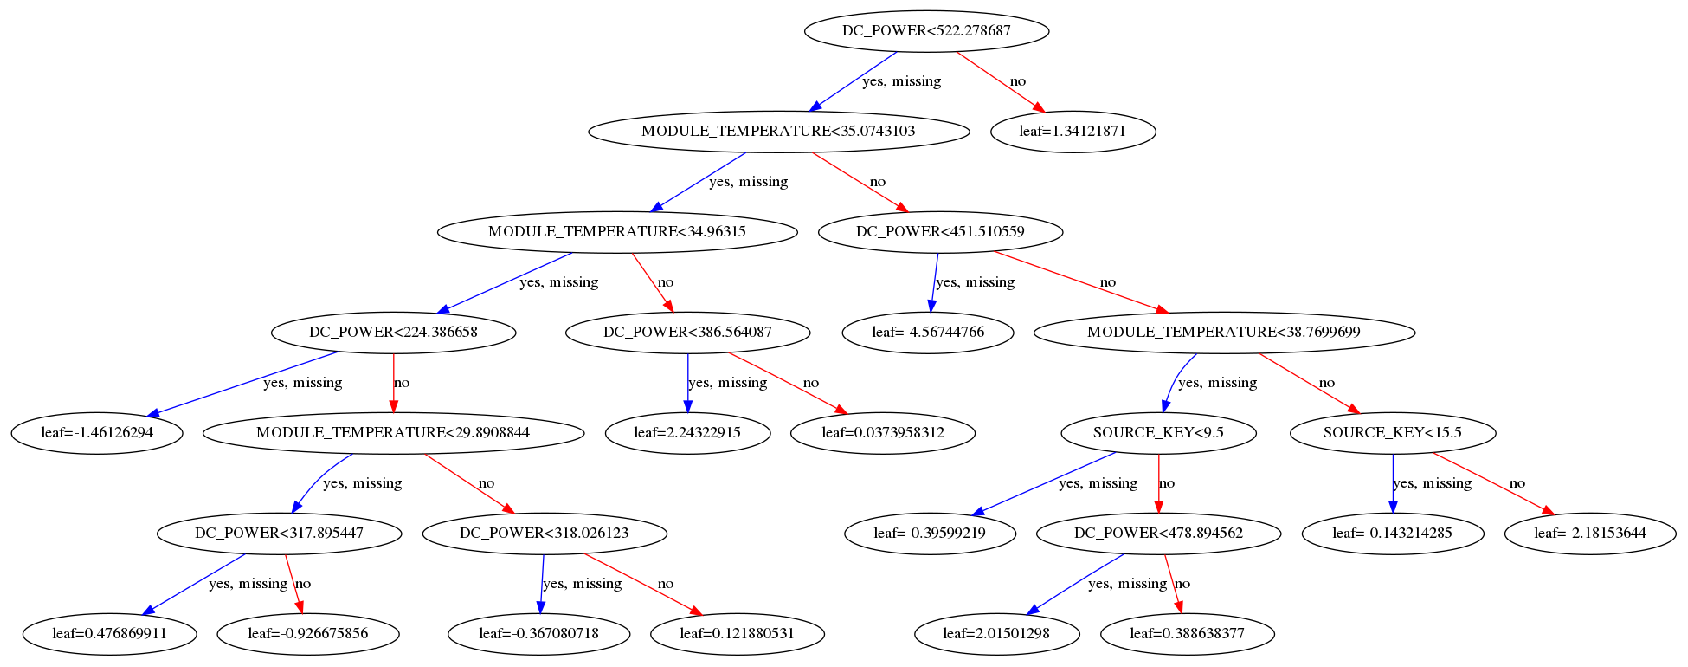

In [13]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(xgbreg, num_trees=119, ax = ax)
plt.show()

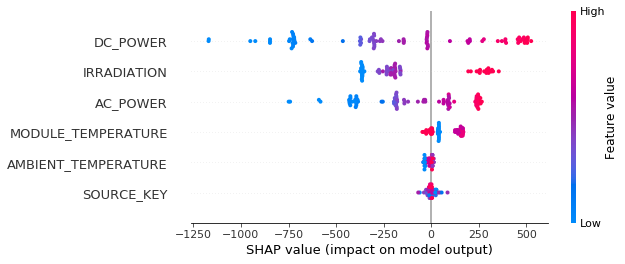

In [14]:
explainer0 = shap.TreeExplainer(xgbreg)
values0 = explainer0.shap_values(X_external)

shap.summary_plot(values0,X_external)

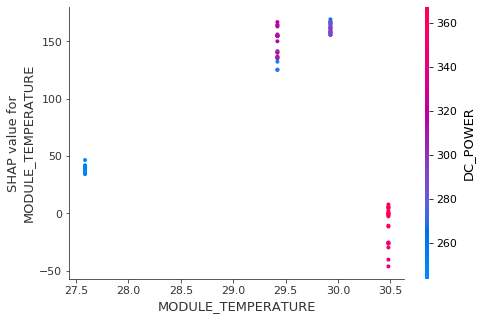

In [15]:
shap.dependence_plot('MODULE_TEMPERATURE',values0,X_external, interaction_index='DC_POWER')

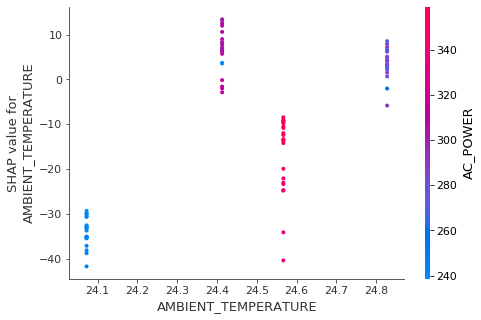

In [16]:
shap.dependence_plot('AMBIENT_TEMPERATURE',values0,X_external, interaction_index='AC_POWER')

# Hypothesis 2:
    HA: It it possible to predict either AC or DC power at given hours of the day using weather data to assume other physical data for the next few days.
    
    H0: It it not enough to provide accurate predictions.

In [17]:
acdchr = result1.groupby(['SOURCE_KEY','DATE','HOUR'])[['DC_POWER','AC_POWER']].agg('mean').reset_index()
irrhr = result1.groupby(['SOURCE_KEY','DATE','HOUR'])[['IRRADIATION','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE']].agg('mean').reset_index()
res1_max = result1.groupby(['SOURCE_KEY','DATE','HOUR'])[['DAILY_YIELD','TOTAL_YIELD']].agg('max').reset_index()
step1 = pd.merge(acdchr, irrhr, how='outer', on =['SOURCE_KEY','DATE','HOUR'])
res1_ts = pd.merge(step1, res1_max, how='outer', on =['SOURCE_KEY','DATE','HOUR'])
res1_ts.head(5)

,SOURCE_KEY,DATE,HOUR,DC_POWER,AC_POWER,IRRADIATION,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,DAILY_YIELD,TOTAL_YIELD
0,1BY6WEcLGh8j5v7,2020-05-15,0,0.0,0.0,0.0,25.012697,22.643083,0.0,6259559.0
1,1BY6WEcLGh8j5v7,2020-05-15,1,0.0,0.0,0.0,24.667328,22.411960,0.0,6259559.0
2,1BY6WEcLGh8j5v7,2020-05-15,2,0.0,0.0,0.0,24.986837,23.512072,0.0,6259559.0
3,1BY6WEcLGh8j5v7,2020-05-15,3,0.0,0.0,0.0,24.954589,24.126433,0.0,6259559.0
4,1BY6WEcLGh8j5v7,2020-05-15,4,0.0,0.0,0.0,24.276670,22.133106,0.0,6259559.0


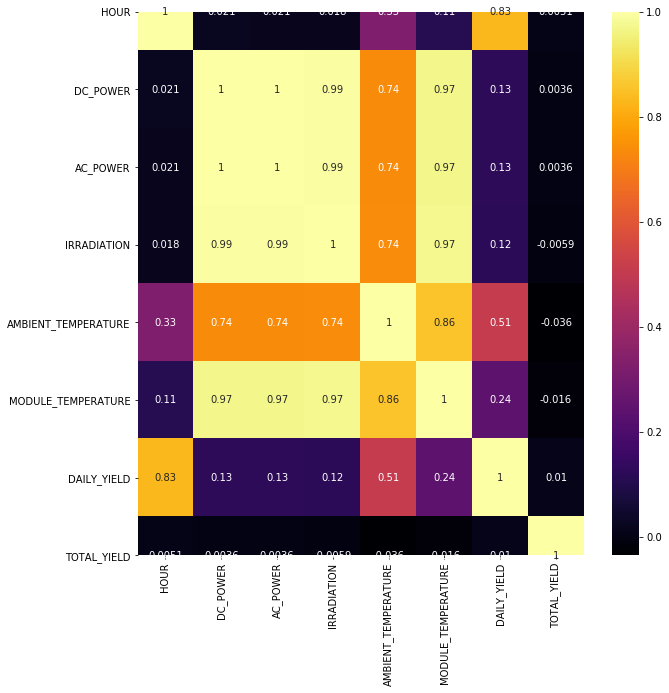

In [19]:
plt.figure(figsize=(10,10))
c = res1_ts.corr(method='pearson')
sns.heatmap(c,cmap='inferno',annot=True)

On an hourly level we see much the same as we did before. Strong linear correlation in most areas with respect to irradiation, and little to no correlation with respect to totaly yield or hour. However that being said we see the same periodic pattern following hourly irradiation.

Considering this there are multiple questions that we can ask:

If we consider the mean values of irradiance, AC/DC_POWER, AMBIENT/MODULE_temperatues as values that can be forecasted similar to weather can we accurately predict the total daily yield for a given inverter for the next several days?

Additionaly, can we use weather data as well as physical module data to predict the hourly AC_POWER for the next several days?

In [20]:
res1_ts['SOURCE_KEY'] = label_encoder.fit_transform(res1_ts['SOURCE_KEY'])
X1 = res1_ts[['SOURCE_KEY','IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','HOUR']]
y1 = res1_ts[['AC_POWER']]
data_mat = xgb.DMatrix(data=X1,label=y1)
X_tr1, X_te1, y_tr1, y_te1 = train_test_split(X1,y1, test_size=0.2,random_state=0)

In [21]:
params = {"objective":"reg:squarederror",'colsample_bytree':0.5,'learning_rate':0.16,
         'max_depth':10,'alpha':10,'min_child_weight':5}

cv_results = xgb.cv(dtrain = data_mat,params=params, nfold=10,
                   num_boost_round=5000,early_stopping_rounds=50,
                   metrics="rmse", as_pandas=True,seed=1)

cv_results.tail(1)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
56,26.227372,1.190302,32.278278,7.830166


In [22]:
reg1 = xgb.XGBRegressor(n_estimators=5000, objective='reg:squarederror',learning_rate=0.16,colsample_bytree = 0.5, max_depth=5, min_child_weight = 5, alpha =10)
reg1.fit(X_tr1, y_tr1, eval_set=[(X_tr1,y_tr1),(X_te1,y_te1)],early_stopping_rounds=50)
time_preds = reg1.predict(X_te1)
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_te1,time_preds))),r2_score(y_te1,time_preds))

[0]	validation_0-rmse:413.50018	validation_1-rmse:413.15369
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:349.01282	validation_1-rmse:348.49969
[2]	validation_0-rmse:294.06641	validation_1-rmse:293.70407
[3]	validation_0-rmse:248.00580	validation_1-rmse:247.78285
[4]	validation_0-rmse:210.62456	validation_1-rmse:210.47040
[5]	validation_0-rmse:179.04658	validation_1-rmse:179.08881
[6]	validation_0-rmse:153.31654	validation_1-rmse:153.65717
[7]	validation_0-rmse:132.14928	validation_1-rmse:132.80031
[8]	validation_0-rmse:115.00806	validation_1-rmse:115.98257
[9]	validation_0-rmse:100.22562	validation_1-rmse:101.35627
[10]	validation_0-rmse:88.06201	validation_1-rmse:89.27456
[11]	validation_0-rmse:76.85110	validation_1-rmse:78.61981
[12]	validation_0-rmse:68.94408	validation_1-rmse:70.75859
[13]	validation_0-rmse:62.62322	validation_1-rmse:64.64574
[14]	

[136]	validation_0-rmse:27.63684	validation_1-rmse:37.16904
[137]	validation_0-rmse:27.63230	validation_1-rmse:37.17123
[138]	validation_0-rmse:27.60048	validation_1-rmse:37.20047
[139]	validation_0-rmse:27.58819	validation_1-rmse:37.19629
[140]	validation_0-rmse:27.57577	validation_1-rmse:37.20391
[141]	validation_0-rmse:27.56506	validation_1-rmse:37.19945
[142]	validation_0-rmse:27.55397	validation_1-rmse:37.19982
[143]	validation_0-rmse:27.54784	validation_1-rmse:37.19212
[144]	validation_0-rmse:27.53647	validation_1-rmse:37.18791
[145]	validation_0-rmse:27.52484	validation_1-rmse:37.18160
[146]	validation_0-rmse:27.51766	validation_1-rmse:37.17468
[147]	validation_0-rmse:27.51226	validation_1-rmse:37.16611
[148]	validation_0-rmse:27.50083	validation_1-rmse:37.16296
[149]	validation_0-rmse:27.49514	validation_1-rmse:37.15925
[150]	validation_0-rmse:27.48995	validation_1-rmse:37.15472
[151]	validation_0-rmse:27.48402	validation_1-rmse:37.15664
[152]	validation_0-rmse:27.47867	validat

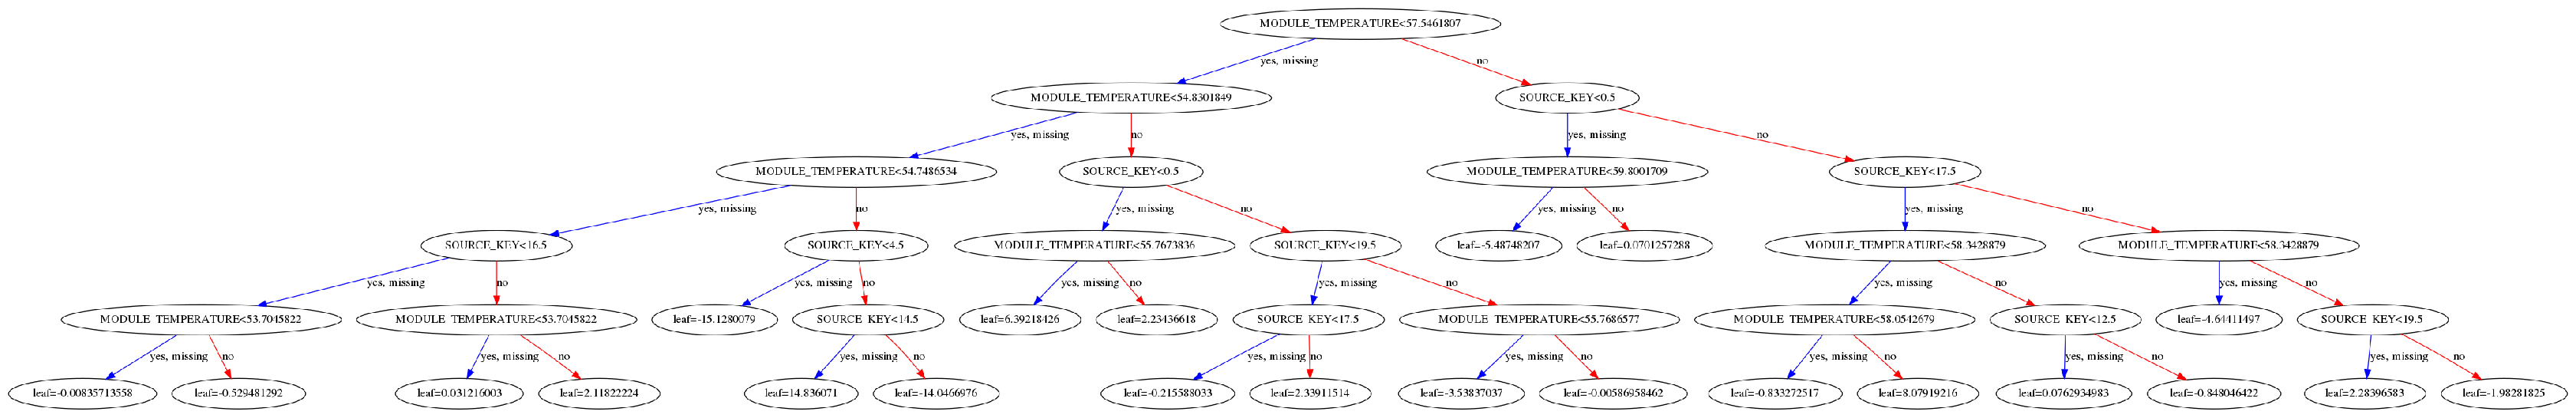

In [24]:
fig, ax = plt.subplots(figsize=(60, 60))
plot_tree(reg1, num_trees=214, ax = ax)
plt.show()

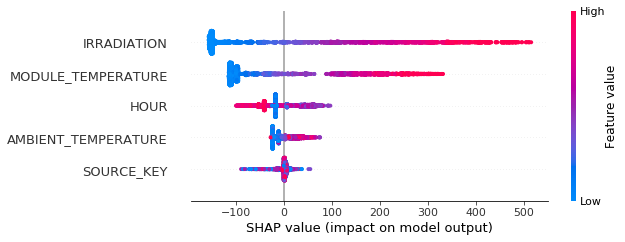

In [25]:
shap_values1 = shap.TreeExplainer(reg1).shap_values(X_te1, check_additivity=False)
shap.summary_plot(shap_values1, X_te1)